<a href="https://colab.research.google.com/github/tinayiluo0322/ECE_Final_Project_2025/blob/main/Thresholad_Address_Imbalance_Garbage_Dataset_Targeted_Adversarial_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adversarial Patch Attack


## Load Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
import os
import random
import numpy as np
import torch

In [3]:
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset, random_split, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from collections import Counter
import shutil
from PIL import Image
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tqdm.notebook import tqdm

In [4]:
seed = 42
random.seed(seed)  # Python's random module
np.random.seed(seed)  # NumPy's random module
torch.manual_seed(seed)  # PyTorch's random seed for CPU
torch.cuda.manual_seed(seed)  # PyTorch's random seed for the current GPU
torch.cuda.manual_seed_all(seed)  # PyTorch's random seed for all GPUs (if using multi-GPU)

# Ensure deterministic behavior on GPU (optional, may slow down training)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Optional: Set environment variables for further reproducibility
os.environ['PYTHONHASHSEED'] = str(seed)

### System Check

In [5]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available.  Training on CPU ...')
else:
  print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


Targeting the unbalanced dataset:

(1) Data Augmentation

transforms.RandomCrop(32, padding=4),
transforms.RandomHorizontalFlip(),
transforms.RandomRotation(15),
transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),

(2) Stratified Splitting

Ensures that each split (train, validation, test) maintains the same class proportions as the original dataset

80% train, 10% val, 10% test

(3) Weighted Sampler

Without any weighting, each sample has an equal probability of being chosen during training. With weighted sampling, we artificially adjust these probabilities to oversample the minority class and undersample the majority class.

In [6]:
import torch
import numpy as np
from torchvision import datasets, transforms
import os
from sklearn.model_selection import train_test_split
from collections import Counter
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler

# Paths and config
DATA_PATH = "/content/drive/MyDrive/two_class_garbage-dataset (1)"
num_workers = 2
batch_size = 32

print('==> Preparing data..')

# Use ImageFolder dataset with default mapping
dataset = datasets.ImageFolder(
    DATA_PATH,
    transform=None  # No transforms yet
)

# Print default class information
print("Classes:", dataset.classes)
print("Default class to index mapping:", dataset.class_to_idx)

# Get targets for stratification
targets = np.array(dataset.targets)

# Print class distribution
class_counts = Counter(targets)
print("Dataset class distribution:")
for class_name in dataset.classes:
    class_idx = dataset.class_to_idx[class_name]
    count = class_counts[class_idx]
    percentage = count / len(targets) * 100
    print(f"  - {class_name} (class {class_idx}): {count} samples ({percentage:.2f}%)")

# Verify the first few samples
print("Verification - First few samples and their classes:")
for i in range(min(5, len(dataset.samples))):
    path, class_idx = dataset.samples[i]
    class_name = dataset.classes[class_idx]
    print(f"  Sample {i}: {path} → Class: {class_name} (index: {class_idx})")

# First split: train vs eval (80/20 split)
train_indices, eval_indices = train_test_split(
    np.arange(len(targets)),
    test_size=0.2,  # 20% for evaluation (will be split into val and test)
    stratify=targets,
    random_state=42
)

# Get labels for the evaluation set for further stratified splitting
eval_targets = targets[eval_indices]

# Second split: validation vs test (50/50 of the eval set, which makes 10/10 of total)
valid_indices, test_indices = train_test_split(
    eval_indices,
    test_size=0.5,  # Split eval set equally between validation and test
    stratify=eval_targets,
    random_state=42
)

print(f"Split proportions: {len(train_indices)}/{len(valid_indices)}/{len(test_indices)} (train/valid/test)")

# Print class distribution after stratified split
train_targets = targets[train_indices]
val_targets = targets[valid_indices]
test_targets = targets[test_indices]

# Print class distribution after stratified split
print("Class distribution after stratified split:")
for class_name in dataset.classes:
    class_idx = dataset.class_to_idx[class_name]
    train_count = np.sum(train_targets == class_idx)
    val_count = np.sum(val_targets == class_idx)
    test_count = np.sum(test_targets == class_idx)

    train_pct = train_count / len(train_targets) * 100
    val_pct = val_count / len(val_targets) * 100
    test_pct = test_count / len(test_targets) * 100

    print(f"{class_name} (class {class_idx}):")
    print(f"  - Train: {train_count} samples ({train_pct:.2f}%)")
    print(f"  - Valid: {val_count} samples ({val_pct:.2f}%)")
    print(f"  - Test:  {test_count} samples ({test_pct:.2f}%)")

# Define the transforms with dataset-specific values
MEAN = [0.6256342530250549, 0.5870475769042969, 0.5542739629745483]
STD = [0.2797325849533081, 0.2854619324207306, 0.2984888553619385]

# Define transforms
transform_train = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

transform_test = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

# Custom wrapper for applying transforms
class TransformedSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        image, label = self.subset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Create subsets
train_set = TransformedSubset(Subset(dataset, train_indices), transform_train)
val_set = TransformedSubset(Subset(dataset, valid_indices), transform_test)
test_set = TransformedSubset(Subset(dataset, test_indices), transform_test)

# Create weighted sampler for handling class imbalance
class_counts = Counter(train_targets)
weights = 1.0 / np.array([class_counts[t] for t in train_targets])
sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

# Prepare data loaders
train_loader = DataLoader(
    train_set, batch_size=batch_size,
    sampler=sampler, num_workers=num_workers
)
valid_loader = DataLoader(
    val_set, batch_size=batch_size,
    shuffle=False, num_workers=num_workers
)
test_loader = DataLoader(
    test_set, batch_size=batch_size,
    shuffle=False, num_workers=num_workers
)

print(f'Number of training samples: {len(train_set)}')
print(f'Number of validation samples: {len(val_set)}')
print(f'Number of test samples: {len(test_set)}')
print(f'Total samples: {len(dataset)}')

# Function to verify balanced sampling
def check_batch_distribution(loader, num_batches=5):
    class_counts = Counter()
    for i, (_, labels) in enumerate(loader):
        if i >= num_batches:
            break
        class_counts.update(labels.numpy())
    print("Sampled batch class distribution:", dict(class_counts))

print("Checking if WeightedRandomSampler is properly balancing batches:")
check_batch_distribution(train_loader)

==> Preparing data..
Classes: ['battery (1)', 'non_battery (1)']
Default class to index mapping: {'battery (1)': 0, 'non_battery (1)': 1}
Dataset class distribution:
  - battery (1) (class 0): 944 samples (4.78%)
  - non_battery (1) (class 1): 18786 samples (95.22%)
Verification - First few samples and their classes:
  Sample 0: /content/drive/MyDrive/two_class_garbage-dataset (1)/battery (1)/battery_1 (1).jpg → Class: battery (1) (index: 0)
  Sample 1: /content/drive/MyDrive/two_class_garbage-dataset (1)/battery (1)/battery_10 (1).jpg → Class: battery (1) (index: 0)
  Sample 2: /content/drive/MyDrive/two_class_garbage-dataset (1)/battery (1)/battery_100 (1).jpg → Class: battery (1) (index: 0)
  Sample 3: /content/drive/MyDrive/two_class_garbage-dataset (1)/battery (1)/battery_101 (1).jpg → Class: battery (1) (index: 0)
  Sample 4: /content/drive/MyDrive/two_class_garbage-dataset (1)/battery (1)/battery_102 (1).jpg → Class: battery (1) (index: 0)
Split proportions: 15784/1973/1973 (tra

## Load Pretrained Models

### Model Definition

In [7]:
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
  expansion = 1
  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.expansion*planes)
      )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class BottleNeck(nn.Module):
  expansion = 4

  def __init__(self, in_planes, planes, stride=1):
    super(BottleNeck, self).__init__()
    self.conv1 = nn.Conv2d(in_planes , planes, kernel_size=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)
    self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
    self.bn3 = nn.BatchNorm2d(self.expansion*planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes :
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.expansion*planes)
      )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)))
    out = self.bn3(self.conv3(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=2):
    super(ResNet, self).__init__()
    self.in_planes = 64

    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
    self.linear = nn.Linear(512*block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, stride))
      self.in_planes = planes * block.expansion
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out

ResNet18 = ResNet(BasicBlock, [2,2,2,2])
#ResNet34 = ResNet(BasicBlock, [3,4,6,3])
#ResNet50 = ResNet(BottleNeck, [3,4,6,3])
#ResNet101 = ResNet(BottleNeck, [3,4,23,3])
#ResNet152 = ResNet(BottleNeck, [3,8,36,3])

print(ResNet18)

if train_on_gpu:
  ResNet18 = torch.nn.DataParallel(ResNet18)
  cudnn.benchmark = True

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

### Add Weighted Loss

Targeting the unbalanced data:

(4) Weighted Loss

* Assign a higher loss for misclassifications of the minority class (battery)

* Make the model pay more attention to correctly classifying battery samples

* Help balance the influence of each class during training

In [8]:

import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter

# Calculate class weights directly using the default class indices
class_counts = Counter(train_targets)
total_samples = len(train_targets)

# Simplify class weight calculation to use indices directly
num_classes = len(dataset.classes)
class_weights = [total_samples / (num_classes * class_counts[i]) for i in range(num_classes)]
class_weights_tensor = torch.FloatTensor(class_weights)

print(f"Class weights: {class_weights_tensor}")

# Move weights to GPU if using CUDA
if torch.cuda.is_available():
    class_weights_tensor = class_weights_tensor.cuda()

# Weighted CrossEntropyLoss - gives more importance to minority class
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

optimizer = optim.SGD(ResNet18.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)

# Print out class distribution for clarity
print("Class distribution:")
for class_name in dataset.classes:
   class_idx = dataset.class_to_idx[class_name]
   count = class_counts[class_idx]
   percentage = count / total_samples * 100
   print(f"{class_name} (class {class_idx}): {count} samples ({percentage:.2f}%)")

Class weights: tensor([10.4530,  0.5251])
Class distribution:
battery (1) (class 0): 755 samples (4.78%)
non_battery (1) (class 1): 15029 samples (95.22%)


### Load Pretrained Model

In [9]:
import torch
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

# Load the saved model
model_path = 'ResNet18_2_class_garbage_train_50.pt'  # Path to your saved model

# Initialize the model with the same architecture
ResNet18 = ResNet(BasicBlock, [2,2,2,2], num_classes=2)

# Handle loading from DataParallel model if needed
if train_on_gpu:
    ResNet18 = ResNet18.cuda()
    state_dict = torch.load(model_path)
    # If the model was saved with DataParallel
    if list(state_dict.keys())[0].startswith('module.'):
        ResNet18 = torch.nn.DataParallel(ResNet18)
        ResNet18.load_state_dict(state_dict)
    else:
        ResNet18.load_state_dict(state_dict)
else:
    state_dict = torch.load(model_path, map_location=torch.device('cpu'))
    # If the model was saved with DataParallel but we're loading on CPU
    if list(state_dict.keys())[0].startswith('module.'):
        from collections import OrderedDict
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k[7:] # remove 'module.' prefix
            new_state_dict[name] = v
        ResNet18.load_state_dict(new_state_dict)
    else:
        ResNet18.load_state_dict(state_dict)

# Set model to evaluation mode
model = ResNet18
# ResNet18.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()
print("Pretrained ResNet18 loaded and ready!")

Pretrained ResNet18 loaded and ready!


## Adversarial Patch Training

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter

def get_weighted_loss(train_targets, dataset, model_parameters, learning_rate=0.01, momentum=0.9, weight_decay=0.0001):
    # Calculate class weights directly using the default class indices
    class_counts = Counter(train_targets)
    total_samples = len(train_targets)

    # Simplify class weight calculation to use indices directly
    num_classes = len(dataset.classes)
    class_weights = [total_samples / (num_classes * class_counts[i]) for i in range(num_classes)]
    class_weights_tensor = torch.FloatTensor(class_weights)

    # Move weights to GPU if using CUDA
    if torch.cuda.is_available():
        class_weights_tensor = class_weights_tensor.cuda()

    # Weighted CrossEntropyLoss - gives more importance to minority classes
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

    # Setup the optimizer
    optimizer = optim.SGD(model_parameters, lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    # Optionally print out class distribution for clarity
    print("Class distribution:")
    for class_name in dataset.classes:
        class_idx = dataset.class_to_idx[class_name]
        count = class_counts[class_idx]
        percentage = count / total_samples * 100
        print(f"{class_name} (class {class_idx}): {count} samples ({percentage:.2f}%)")

    return criterion, optimizer

# Example usage:
# Assuming 'train_targets', 'dataset', and 'model_parameters' are predefined
# criterion, optimizer = get_weighted_loss(train_targets, dataset, ResNet18.parameters())


In [12]:
# Function to create a random patch
def create_patch(patch_size=(3, 3)):
    patch = torch.randn(3, *patch_size, requires_grad=True, device=device)
    return patch

# Function to apply the patch to images
def place_patch(img, patch):
    batch_size, _, h, w = img.size()
    ph, pw = patch.size(1), patch.size(2)
    for i in range(batch_size):
        x_offset = torch.randint(0, h - ph + 1, (1,)).item()
        y_offset = torch.randint(0, w - pw + 1, (1,)).item()
        img[i, :, x_offset:x_offset+ph, y_offset:y_offset+pw] = patch
    return img

# Training function for adversarial patch
def patch_training_step(model, patch, target_class=None, dataloader=None, optimizer=None, criterion=None):
    model.train()
    total_loss = 0
    for images, _ in dataloader:
        images = images.to(device)
        optimizer.zero_grad()
        patched_images = place_patch(images, patch)
        outputs = model(patched_images)
        if target_class is not None:
            labels = torch.full((images.size(0),), target_class, dtype=torch.long, device=device)
        else:
            labels = torch.randint(0, 10, (images.size(0),), device=device)  # Random class for untargeted attack
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)

# Function to train the adversarial patch
def train_adversarial_patch(model, patch, target_class=None, num_epochs=10):
    patch_optimizer = optim.Adam([patch], lr=0.01)
    criterion, _ = get_weighted_loss(train_targets, dataset, model.parameters())
    for epoch in range(num_epochs):
        loss = patch_training_step(model, patch, target_class, train_loader, patch_optimizer, criterion)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")

# Function to evaluate the success rate of the adversarial patch
def evaluate_patch(model, patch, dataloader, target_class=None):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            patched_images = place_patch(images, patch)
            outputs = model(patched_images)
            _, predicted = outputs.max(1)
            if target_class is not None:
                correct += (predicted == target_class).sum().item()
            else:
                correct += (predicted != labels).sum().item()  # Evaluate untargeted attack
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Attack Success Rate: {accuracy:.2f}%")



# Function to visualize the patch
def visualize_patch(patch):
    patch = patch.detach().cpu().numpy()
    patch = np.clip((patch - patch.min()) / (patch.max() - patch.min()), 0, 1)

    plt.figure(figsize=(2, 2))
    plt.imshow(np.transpose(patch, (1, 2, 0)))  # [C, H, W] -> [H, W, C]
    plt.title("Adversarial Patch")
    plt.axis('off')
    plt.show()

# Function to visualize misclassified patched images
def visualize_misclassified_patched_images(model, patch, dataloader, classes, target_class, num_examples=5):
    model.eval()
    examples_shown = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        patched_images = place_patch(images.clone(), patch)
        with torch.no_grad():
            original_preds = model(images).argmax(dim=1)
            patched_preds = model(patched_images).argmax(dim=1)
        for i in range(images.size(0)):
            if patched_preds[i] == target_class:  # Targeted attack
                original_image = (images[i].cpu().detach().numpy().transpose(1, 2, 0) * 0.5) + 0.5
                patched_image = (patched_images[i].cpu().detach().numpy().transpose(1, 2, 0) * 0.5) + 0.5

                fig, axes = plt.subplots(1, 2, figsize=(4, 4))
                axes[0].imshow(np.clip(original_image, 0, 1))
                axes[0].set_title(f"Original Image\nTrue Label: {classes[labels[i].item()]}\nPredicted: {classes[original_preds[i].item()]}")

                axes[1].imshow(np.clip(patched_image, 0, 1))
                axes[1].set_title(f"Image with Adversarial Patch\nTrue Label: {classes[labels[i].item()]}\nPredicted: {classes[patched_preds[i].item()]}")

                plt.show()
                examples_shown += 1
                if examples_shown >= num_examples:
                    return

## Threshold


===== Evaluating Patch Targeting Class 0 =====


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


Test Accuracy: 0.0482

Test Metrics by Class:
Class 0	Precision: 0.0482	Recall: 1.0000	F1-Score: 0.0919
Class 1	Precision: 0.0000	Recall: 0.0000	F1-Score: 0.0000

Test Confusion Matrix:
[[  95    0]
 [1878    0]]

Detailed Test Classification Report:
              precision    recall  f1-score   support

           0       0.05      1.00      0.09        95
           1       0.00      0.00      0.00      1878

    accuracy                           0.05      1973
   macro avg       0.02      0.50      0.05      1973
weighted avg       0.00      0.05      0.00      1973



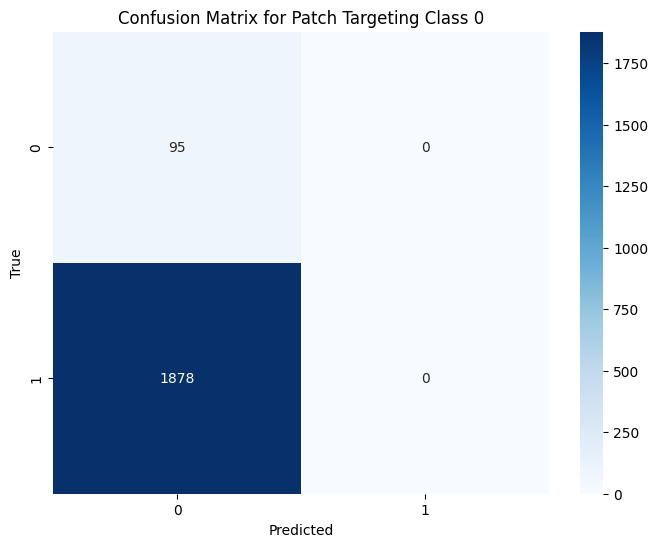

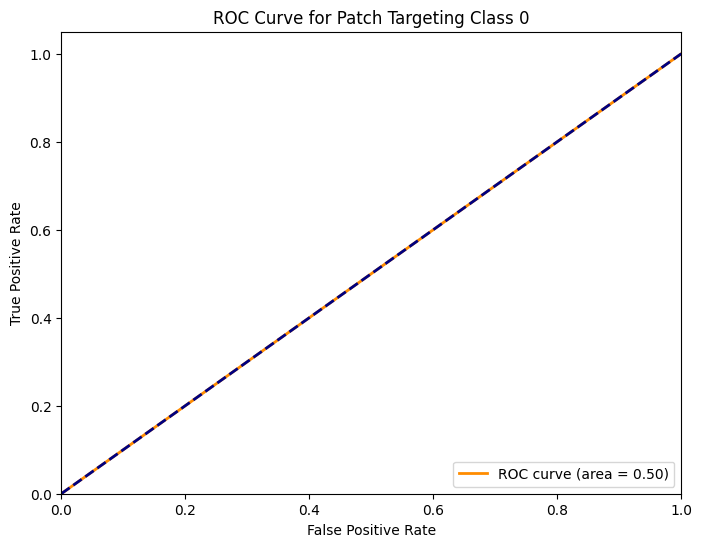


===== Evaluating Patch Targeting Class 1 =====


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


Test Accuracy: 0.0482

Test Metrics by Class:
Class 0	Precision: 0.0482	Recall: 1.0000	F1-Score: 0.0919
Class 1	Precision: 0.0000	Recall: 0.0000	F1-Score: 0.0000

Test Confusion Matrix:
[[  95    0]
 [1878    0]]

Detailed Test Classification Report:
              precision    recall  f1-score   support

           0       0.05      1.00      0.09        95
           1       0.00      0.00      0.00      1878

    accuracy                           0.05      1973
   macro avg       0.02      0.50      0.05      1973
weighted avg       0.00      0.05      0.00      1973



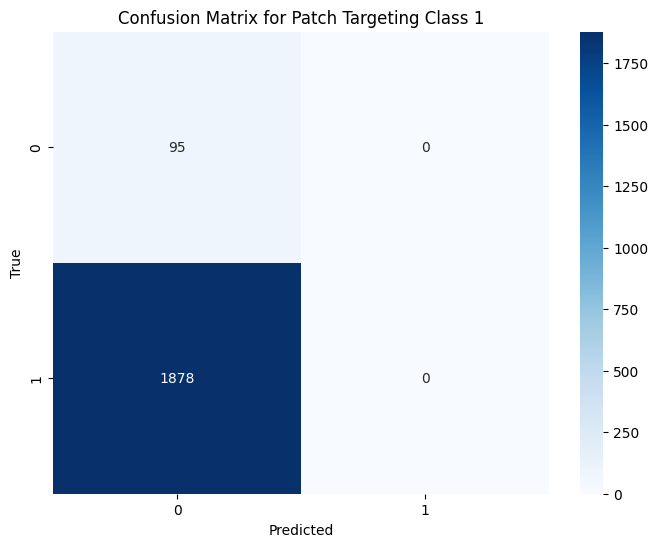

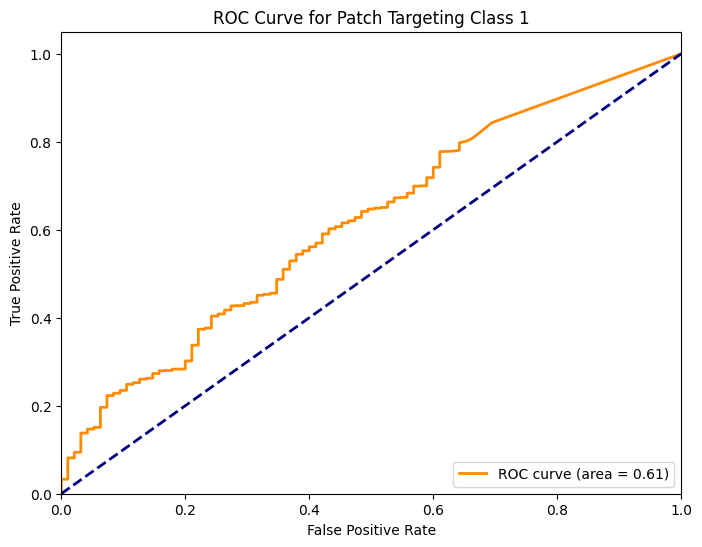

In [14]:
import torch
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Load the patches for class 0 and class 1
patch_class0 = torch.load('adversarial_patch_16x16_target_0.pth')
patch_class1 = torch.load('adversarial_patch_16x16_target_1.pth')

# Move patches to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
patch_class0 = patch_class0.to(device)
patch_class1 = patch_class1.to(device)

# Set patches to evaluation mode (don't require gradients)
patch_class0.requires_grad = False
patch_class1.requires_grad = False

# Define your place_patch function
def place_patch(img, patch):
    batch_size, _, h, w = img.size()
    ph, pw = patch.size(1), patch.size(2)
    for i in range(batch_size):
        x_offset = torch.randint(0, h - ph + 1, (1,)).item()
        y_offset = torch.randint(0, w - pw + 1, (1,)).item()
        img[i, :, x_offset:x_offset+ph, y_offset:y_offset+pw] = patch
    return img

# Class names now are simple string versions of 0 and 1
class_names = ["0", "1"]

# Load model
model_path = 'ResNet18_2_class_garbage_train_50.pt'
ResNet18 = ResNet(BasicBlock, [2,2,2,2], num_classes=2)

# Handle DataParallel loading
state_dict = torch.load(model_path, map_location=device)
if list(state_dict.keys())[0].startswith('module.'):
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:]  # remove 'module.' prefix
        new_state_dict[name] = v
    ResNet18.load_state_dict(new_state_dict)
else:
    ResNet18.load_state_dict(state_dict)

ResNet18 = ResNet18.to(device)
ResNet18.eval()

# Evaluation function
def evaluate_with_patch(model, patch, target_class_label):
    test_preds = []
    test_targets = []
    test_probs = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            # Apply patch
            patched_data = place_patch(data.clone(), patch)

            # Forward pass
            output = model(patched_data)
            probs = torch.nn.functional.softmax(output, dim=1)
            _, preds = torch.max(output, 1)

            test_preds.extend(preds.cpu().numpy())
            test_targets.extend(target.cpu().numpy())
            test_probs.extend(probs[:, target_class_label].cpu().numpy())  # Save probability for ROC

    return np.array(test_targets), np.array(test_preds), np.array(test_probs)

# Evaluate each patch separately
for target_class_label, patch in zip([0, 1], [patch_class0, patch_class1]):
    print(f"\n===== Evaluating Patch Targeting Class {target_class_label} =====")

    test_targets, test_preds, test_probs = evaluate_with_patch(ResNet18, patch, target_class_label)

    # Metrics
    test_accuracy = accuracy_score(test_targets, test_preds)
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_targets, test_preds, average=None, labels=[0, 1])
    test_cm = confusion_matrix(test_targets, test_preds)

    print(f'\nTest Accuracy: {test_accuracy:.4f}')
    print('\nTest Metrics by Class:')
    for i in range(2):
        print(f'Class {i}\tPrecision: {test_precision[i]:.4f}\tRecall: {test_recall[i]:.4f}\tF1-Score: {test_f1[i]:.4f}')

    print("\nTest Confusion Matrix:")
    print(test_cm)

    print("\nDetailed Test Classification Report:")
    print(classification_report(test_targets, test_preds, target_names=class_names))

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for Patch Targeting Class {target_class_label}')
    plt.savefig(f'confusion_matrix_patch_target_{target_class_label}.png')
    plt.show()

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(test_targets, test_probs, pos_label=target_class_label)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Patch Targeting Class {target_class_label}')
    plt.legend(loc="lower right")
    plt.savefig(f'roc_curve_patch_target_{target_class_label}.png')
    plt.show()



Battery Class (Class 0, Patched Images) TPR-FPR Analysis:
Target TPR     Actual TPR     FPR            Threshold      
------------------------------------------------------------
0.99           1.0000         1.0000         1.0000         
0.95           1.0000         1.0000         1.0000         
0.90           1.0000         1.0000         1.0000         
0.85           1.0000         1.0000         1.0000         
0.80           1.0000         1.0000         1.0000         


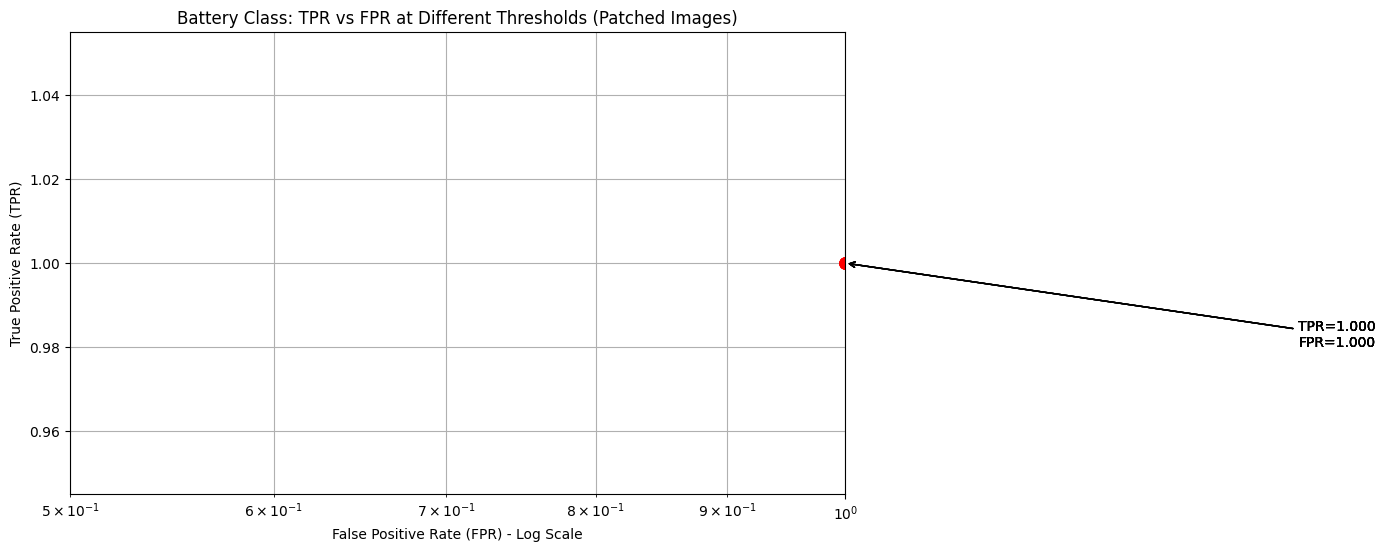

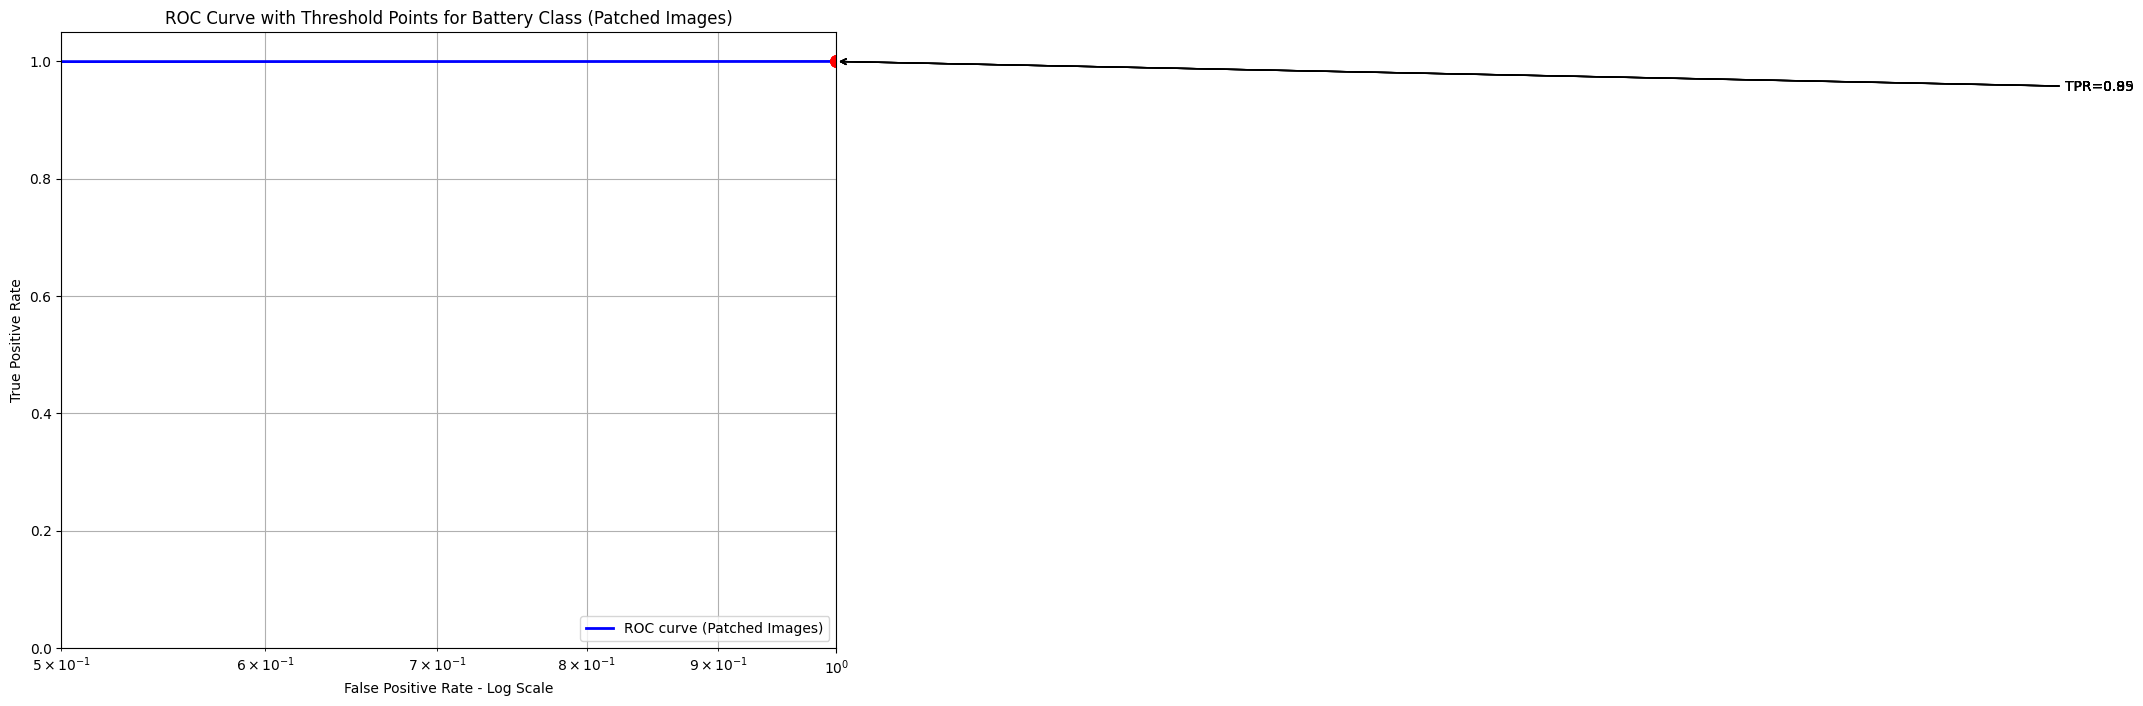


Summary of Battery Class TPR-FPR Relationship (Patched Images):
Target TPR     Actual TPR     FPR            TPR/FPR Ratio  
------------------------------------------------------------
0.99           1.0000         1.0000         1.0000         
0.95           1.0000         1.0000         1.0000         
0.90           1.0000         1.0000         1.0000         
0.85           1.0000         1.0000         1.0000         
0.80           1.0000         1.0000         1.0000         


In [16]:
import torch
import numpy as np
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Set model to evaluation mode
ResNet18.eval()

# First, collect all predictions and ground truth
all_targets = []
all_probs = []

# Get probabilities from the model
with torch.no_grad():
    for data, target in test_loader:
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # >>> Apply the adversarial patch here <<<
        patched_data = place_patch(data.clone(), patch_class0)

        # Forward pass
        output = ResNet18(patched_data)

        # Convert to probabilities
        probs = torch.nn.functional.softmax(output, dim=1)

        # Store probabilities and targets
        all_probs.extend(probs.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

# Convert to numpy arrays
all_probs = np.array(all_probs)
all_targets = np.array(all_targets)

# Extract probability for the battery class (assuming it's class 0)
battery_probs = all_probs[:, 0]

# List of target TPRs for the battery class
target_tprs = [0.99, 0.95, 0.90, 0.85, 0.80]

# Function to find threshold for a target TPR
def find_threshold_for_tpr(y_true, y_score, target_tpr, positive_class=0):
    binary_y_true = (y_true == positive_class).astype(int)
    fpr, tpr, thresholds = roc_curve(binary_y_true, y_score)
    idx = np.argmin(np.abs(tpr - target_tpr))
    return thresholds[idx], fpr[idx], tpr[idx]

# Store TPR and FPR results
results = []

print("\nBattery Class (Class 0, Patched Images) TPR-FPR Analysis:")
print(f"{'Target TPR':<15}{'Actual TPR':<15}{'FPR':<15}{'Threshold':<15}")
print("-" * 60)

# Calculate thresholds and corresponding FPR for each target TPR
for target_tpr in target_tprs:
    threshold, fpr, actual_tpr = find_threshold_for_tpr(all_targets, battery_probs, target_tpr)
    results.append((target_tpr, actual_tpr, fpr, threshold))
    print(f"{target_tpr:<15.2f}{actual_tpr:<15.4f}{fpr:<15.4f}{threshold:<15.4f}")

# Plot TPR vs FPR relationship with log scale for FPR
plt.figure(figsize=(10, 6))
tprs = [r[1] for r in results]
fprs = [r[2] for r in results]

# Plot the points
plt.semilogx(fprs, tprs, 'ro-', markersize=8)  # Using semilogx for log scale on x-axis

# Add data labels
for i, (target_tpr, actual_tpr, fpr, _) in enumerate(results):
    plt.annotate(f"TPR={actual_tpr:.3f}\nFPR={fpr:.3f}",
                 xy=(fpr, actual_tpr),
                 xytext=(fpr*1.5, actual_tpr-0.02),  # Adjusted for log scale
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

plt.xlabel('False Positive Rate (FPR) - Log Scale')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Battery Class: TPR vs FPR at Different Thresholds (Patched Images)')
plt.grid(True, which="both", ls="-")
plt.xlim([min(fprs)*0.5, 1.0])
plt.savefig('battery_tpr_vs_fpr_log_patched.png')
plt.show()

# Also plot ROC curve with log scale
plt.figure(figsize=(10, 8))

# Calculate full ROC curve
binary_targets = (all_targets == 0).astype(int)
fpr_full, tpr_full, _ = roc_curve(binary_targets, battery_probs)

# Plot ROC curve with log scale
plt.semilogx(fpr_full, tpr_full, 'b-', lw=2, label='ROC curve (Patched Images)')

# Plot threshold points
for i, (target_tpr, actual_tpr, fpr, _) in enumerate(results):
    plt.plot(fpr, actual_tpr, 'ro', markersize=8)
    plt.annotate(f"TPR={target_tpr}",
                 xy=(fpr, actual_tpr),
                 xytext=(fpr*3, actual_tpr-0.05),
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

plt.xlim([min(fpr_full[fpr_full > 0])*0.5, 1.0])  # Avoid log(0) error by finding minimum non-zero FPR
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate - Log Scale')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Threshold Points for Battery Class (Patched Images)')
plt.legend(loc="lower right")
plt.grid(True, which="both", ls="-")
plt.savefig('battery_roc_with_thresholds_log_patched.png')
plt.show()

# Create a table of results
print("\nSummary of Battery Class TPR-FPR Relationship (Patched Images):")
print(f"{'Target TPR':<15}{'Actual TPR':<15}{'FPR':<15}{'TPR/FPR Ratio':<15}")
print("-" * 60)

for target_tpr, actual_tpr, fpr, _ in results:
    ratio = actual_tpr / fpr if fpr > 0 else float('inf')
    print(f"{target_tpr:<15.2f}{actual_tpr:<15.4f}{fpr:<15.4f}{ratio:<15.4f}")